# Präsenzversuch zum Laval-Rotor

Name: Benjamin Schmidt

Datum: 08.02.2024

Gruppe: 42

## Forschungsfrage

Formulieren Sie eine oder mehrere Forschungsfragen zu der Lerneinheit:

Können in den Campbell Diagrammen zu den unterschiedlichen Laval-Rotoren die analytisch berechneten kritischen Drehzahlen wiedergefunden werden? Wie unterscheiden sich die Eigenfrequenzen der drei verschiedenen Laval-Rotoren?

## Erster Versuch: Prüfstand 02
Hier werden Sie die Messergebnisse des ersten Prüfstands auswerten. Die Auswertung des zweiten Prüfstands kann analog erfolgen, die entsprechenden jupyter-notebook-Zellen sind weiter unten vorbereitet.
Bitte ergänzen Sie im Titel der Markdown-Zellen die Nummer des Prüfstands

###  Versuchsaufbau
- Bild des Prüfstands:

<img src="figures/pruefstand1.jpg" width="900">

- Beschreibung des Aufbaus, gehen Sie auf die Anzahl der Scheiben und deren Gewicht ein:

Der Prüfstand besteht aus einer Welle, einer Lagerung, zwei Scheiben, zwei Fanglagern, einem bürstenlosen Gleichstrommotor, einer Einhausung, einem Beschleunigungssensor und einem Schaltschrank. Die Welle ist 0,75 m lang und ist fest-los-gelagert. Die beiden Scheiben sitzen jeweils 0,25 m von einem der Lager entfernt und zwischen den Scheiben ist ebenfalls ein Abstand von 0,25 m gegeben. Beide Scheiben haben eine Masse von 500 g. Um eine Zerstörung der Welle bei Resonanz zu verhindern, ist neben den Scheiben jeweils ein Fanglager positioniert, durch welches die Welle bei großen Schwingradien blockiert wird. Die Einhausung umfasst alle anderen Komponenten des Prüfstands und verhindert, dass Gegenstände oder Körperteile in die Nähe der rotierenden Teile kommen und verhindert bei Versagen der Scheibe oder der Welle eine Verletzung der umstehenden Personen. Im Schaltschrank befindet sich neben verschiedenen sicherheitstechnischen Elementen ein Raspberry Pi, welcher zur Steuerung des Versuches und zur Aufnahme und Speicherung der Messdaten verwendet wird.

### Versuchsauswertung

In [1]:
import os
import h5py
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import importlib
import json

from functions import m_postprocessing

path = os.path.join("supplementary_code", "FST.mplstyle")
plt.style.use(path)

#### 1. Einlesen der Mess- und Metadaten

Beim Einlesen der Mess- und Metadaten geben wir Ihnen bereits eine Struktur vor. Es bietet sich an diese zu verwenden, ist aber nicht zwingend erforderlich.

##### 1.a) Angabe der Pfade und Dateinamen
Passen Sie die unten stehenden Pfade an, indem Sie `None` ersetzen.

In [2]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240119_140801_lavalrotor_42_02"
)  # path to the folder with H5-file and metadata
filename = "/data_20240119_140801_lavalrotor_42_02.h5"  # name of the H5-file

##### 1.b) Preparieren der Metadaten
Wenn Sie die Pfade oben korrekt definiert haben, dann müssen Sie hier nichts anpassen. Schauen Sie sich die Struktur von `setup_dict` an und die zurückgegebenen IDs `uuid_acceleration` und `uuid_motor_rpm`.

In [3]:
# Extract measurement metadata
setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))

# Save uuids of measuring devices
uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)

{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "measurement_data/data_20240119_140801_lavalrotor_42_02/1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823cc-06c7-631a-99e2-dc18593ae07a": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240119_140801_lavalrotor_42_02/1ee823cc-06c7-631a-99e2-dc18593ae07a.json"
  },
  "1ee823b3-32d9-6d20-8261-106b0e021eed": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "measurement_data/data_20240119_140801_lavalrotor_42_02/1ee823b3-32d9-6d20-8261-106b0e021eed.json"
  },
  "1ee82398-0056-698f-8809-248cede81c54": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "measurement_data/data_20240119_140801_lavalrotor_42_02/1ee82398-0056-698f-8809-248cede81c54.json"
  },
  "1ee823d3-8511-6a0b-8cd5-972f083673c9": {
    "type": "sensor",
  

##### 1.c) Initialisieren der Datenstrukturen für die Messdaten
Hier wird der Vektor `interpolation_points` mit Stützstellen für die Interplation der Messdaten für alle Drehzahlen erzeugt. Dieses vereinfacht später die Darstellung des Campbell-Diagramms enorm.

Initialisieren Sie Datenstrukturen um alle nötigen Daten für das Campbell-Diragramm abspeichern zu können, verwenden Sie dazu ggf. `interpolation_points`.

In [4]:
measurement_time_in_s = 10
number_interpolation_points = 2000

# Initialize interpolation points
interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)

In [5]:
# Read hdf5-file data
with h5py.File(path_measurement_folder + filename, "r") as f:
    # Save and sort keys of hdf5-file
    keys = [eval(i) for i in list(f.keys())]
    keys.sort()
    keys = [str(x) for x in keys]
    
    # Initialize lists to store measurement data
    acc_x = []
    acc_y = []
    acc_z = []
    timestamps = []
    motor_rpm = []
    
    # Append measurement data vectors to corresponding lists
    for i in keys:
        grp = f[i]["RawData"]
        acc_x.append(np.array(grp[uuid_acceleration]["acceleration_x"]))
        acc_y.append(np.array(grp[uuid_acceleration]["acceleration_y"]))
        acc_z.append(np.array(grp[uuid_acceleration]["acceleration_z"]))
        timestamps.append(np.array(grp[uuid_acceleration]["timestamp"]))
        motor_rpm.append(np.array(grp[uuid_motor_rpm]["motor_rpm"]))

# Convert lists of acceleration vectors into numpy arrays
acc_x = np.array(acc_x, dtype=object)
acc_y = np.array(acc_y, dtype=object)
acc_z = np.array(acc_z, dtype=object)

#### 2. Verarbeitung der Messdaten

Verarbeiten Sie die Messdaten für alle untersuchten Drehzahlen mit `m_postprocessing.get_vec_accel()`, `m_postprocessing.interpolation()` und `m_postprocessing.my_fft_scaled()`.

In [6]:
importlib.reload(m_postprocessing)  # reload functions

# Calculate absolute values of acceleration
acc_abs = []
for i in range(len(acc_x)):
    acc_abs.append(m_postprocessing.get_vec_accel(acc_x[i], acc_y[i], acc_z[i]))
acc_abs = np.array(acc_abs, dtype=object)

# Interpolate data
int_data = []
for i in range(len(acc_x)):
    int_data.append(m_postprocessing.interpolation(timestamps[i], acc_abs[i], interpolation_points))
int_data = np.array(int_data, dtype=object)

# Fast fourier transformation
amps = []
freqs = []
for i in range(len(acc_x)):
    [amp, freq] = m_postprocessing.my_fft_scaled(int_data[i], interpolation_points)
    amps.append(np.transpose(np.array(amp)))
    freqs.append(np.transpose(np.array(freq)))

#### 3. Darstellung mittels Campbell-Diagramm

Erzeugen Sie hier ein Campbell-Diagramm aus den Messdaten.

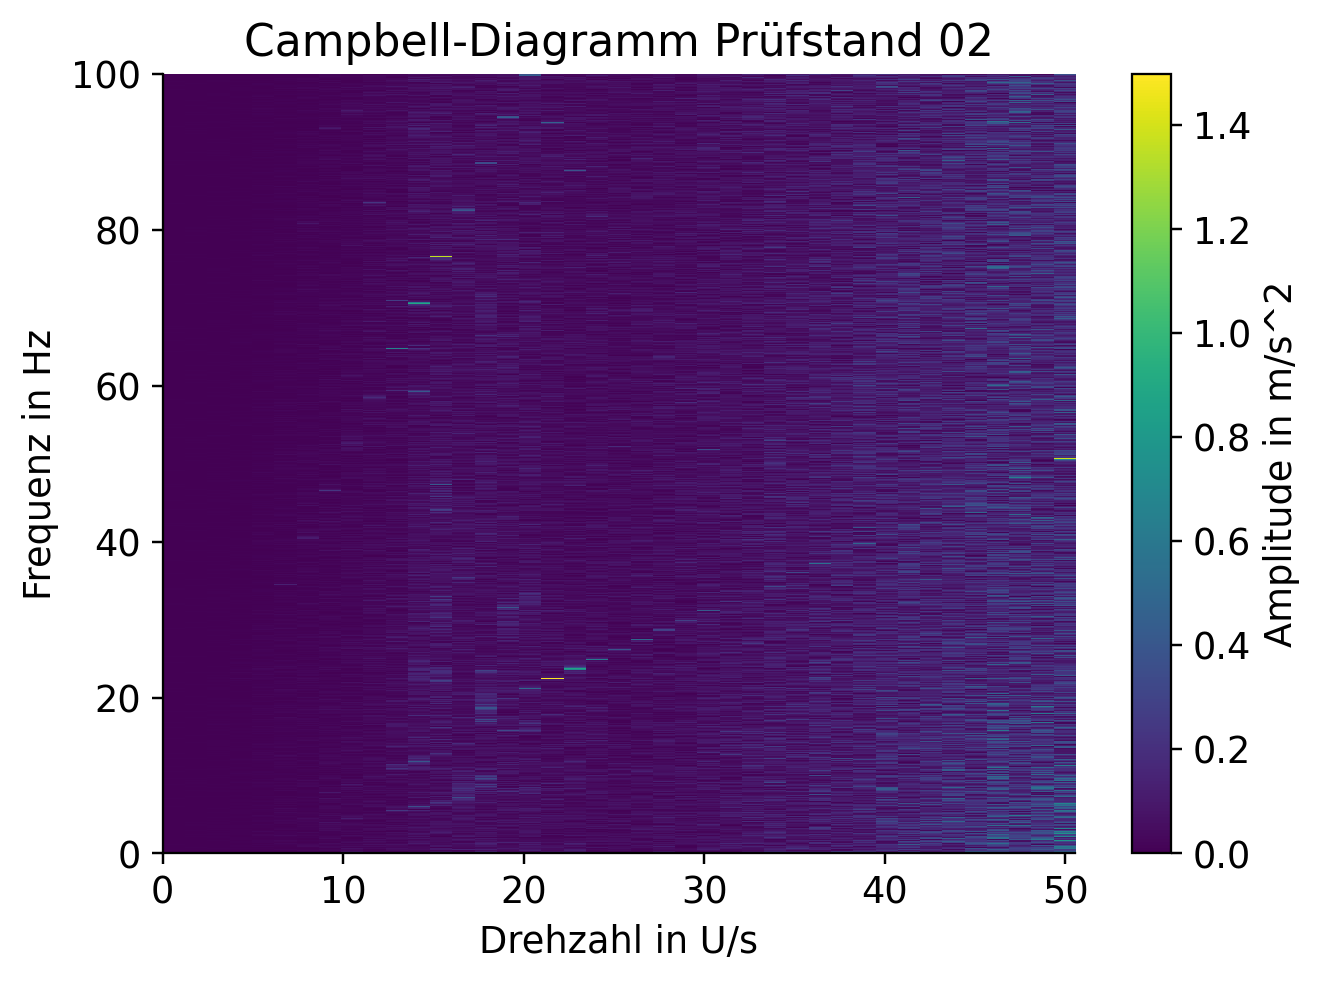

In [7]:
# Plot the Campbell Diagram
plt.imshow(np.transpose(amps), extent =[0, max(motor_rpm)/60, 0, 100], interpolation ='none', aspect ='auto', origin ='lower')
plt.xlabel('Drehzahl in U/s')
plt.ylabel('Frequenz in Hz')
plt.title('Campbell-Diagramm Prüfstand 02')
plt.colorbar(label='Amplitude in m/s^2')

## Zweiter Datensatz: Prüfstand 03

#### 1. Einlesen der Mess- und Metadaten

In [8]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240102_112539_lavalrotor_01_03"
)  # path to the folder with H5-file and metadata
filename = "/data_20240102_112539_lavalrotor_01_03.h5"  # name of the H5-file

In [9]:
# Extract measurement metadata
setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))

# Save uuids of measuring devices
uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)

{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823cd-7650-61c2-9b01-d4744d892e2a": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee823cd-7650-61c2-9b01-d4744d892e2a.json"
  },
  "1ee823b5-5d9b-6f24-9817-906ef09da71d": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee823b5-5d9b-6f24-9817-906ef09da71d.json"
  },
  "1ee8239a-489e-66bc-932e-2587341b8ad5": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee8239a-489e-66bc-932e-2587341b8ad5.json"
  },
  "1ee823d5-1451-6df6-a364-c723014c91a1": {
    "type": "sensor",
  

In [10]:
measurement_time_in_s = 10
number_interpolation_points = 2000

# Initialize interpolation points
interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)

In [11]:
# Read hdf5-file data
with h5py.File(path_measurement_folder + filename, "r") as f:
    # Save and sort keys of hdf5-file
    keys = [eval(i) for i in list(f.keys())]
    keys.sort()
    keys = [str(x) for x in keys]
    
    # Initialize lists to store measurement data
    acc_x = []
    acc_y = []
    acc_z = []
    timestamps = []
    motor_rpm = []
    
    # Append measurement data vectors to corresponding lists
    for i in keys:
        grp = f[i]["RawData"]
        acc_x.append(np.array(grp[uuid_acceleration]["acceleration_x"]))
        acc_y.append(np.array(grp[uuid_acceleration]["acceleration_y"]))
        acc_z.append(np.array(grp[uuid_acceleration]["acceleration_z"]))
        timestamps.append(np.array(grp[uuid_acceleration]["timestamp"]))
        motor_rpm.append(np.array(grp[uuid_motor_rpm]["motor_rpm"]))

# Convert lists of acceleration vectors into numpy arrays
acc_x = np.array(acc_x, dtype=object)
acc_y = np.array(acc_y, dtype=object)
acc_z = np.array(acc_z, dtype=object)

#### 2. Verarbeitung der Messdaten

In [12]:
importlib.reload(m_postprocessing)  # reload functions

# Calculate absolute values of acceleration
acc_abs = []
for i in range(len(acc_x)):
    acc_abs.append(m_postprocessing.get_vec_accel(acc_x[i], acc_y[i], acc_z[i]))
acc_abs = np.array(acc_abs, dtype=object)

# Interpolate data
int_data = []
for i in range(len(acc_x)):
    int_data.append(m_postprocessing.interpolation(timestamps[i], acc_abs[i], interpolation_points))
int_data = np.array(int_data, dtype=object)

# Fast fourier transformation
amps = []
freqs = []
for i in range(len(acc_x)):
    [amp, freq] = m_postprocessing.my_fft_scaled(int_data[i], interpolation_points)
    amps.append(np.transpose(np.array(amp)))
    freqs.append(np.transpose(np.array(freq)))

#### 3. Darstellung mittels Campbell-Diagramm

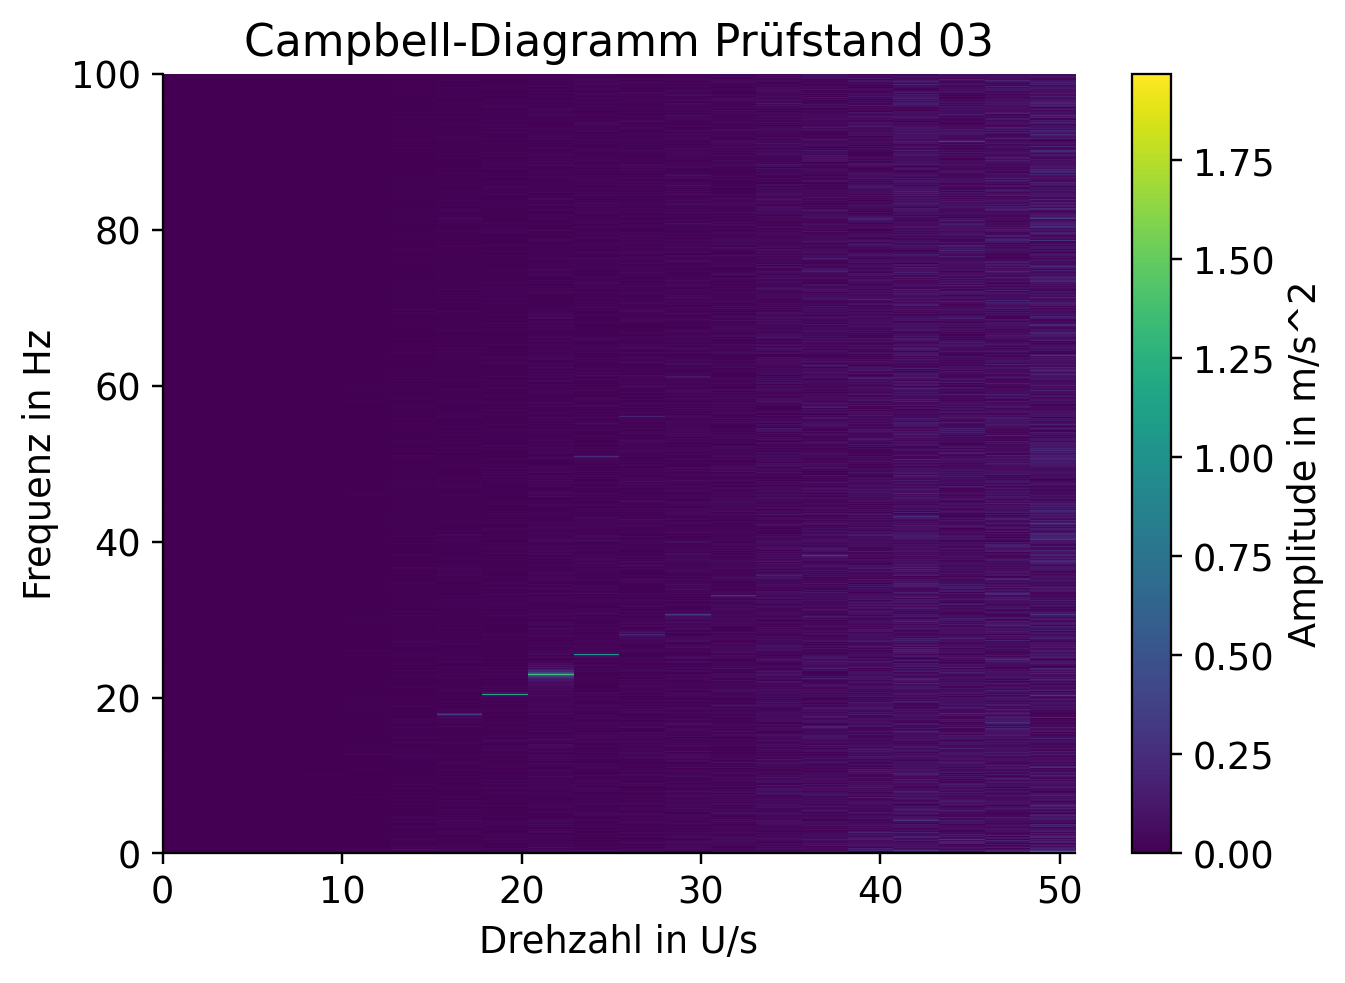

In [13]:
# Plot the Campbell Diagram
plt.imshow(np.transpose(amps), extent =[0, max(motor_rpm)/60, 0, 100], interpolation ='none', aspect ='auto', origin ='lower')
plt.xlabel('Drehzahl in U/s')
plt.ylabel('Frequenz in Hz')
plt.title('Campbell-Diagramm Prüfstand 03')
plt.colorbar(label='Amplitude in m/s^2')

## Dritter Datensatz: Prüfstand 04

#### 1. Einlesen der Mess- und Metadaten

In [14]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240109_104244_lavalrotor_01_04"
)  # path to the folder with H5-file and metadata
filename = "/data_20240109_104244_lavalrotor_01_04.h5"  # name of the H5-file

In [15]:
# Extract measurement metadata
setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))

# Save uuids of measuring devices
uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)

{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "measurement_data/data_20240109_104244_lavalrotor_01_04/1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823ce-82b9-6d4e-a621-60af4e6f5cc1": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240109_104244_lavalrotor_01_04/1ee823ce-82b9-6d4e-a621-60af4e6f5cc1.json"
  },
  "1ee823b6-50dc-6670-aea5-35f6dd717e83": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "measurement_data/data_20240109_104244_lavalrotor_01_04/1ee823b6-50dc-6670-aea5-35f6dd717e83.json"
  },
  "1ee8239b-46ec-63dc-8aa4-b8751ac37fd3": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "measurement_data/data_20240109_104244_lavalrotor_01_04/1ee8239b-46ec-63dc-8aa4-b8751ac37fd3.json"
  },
  "1ee823d6-3d20-6332-83f5-6876b760dcf3": {
    "type": "sensor",
  

In [16]:
measurement_time_in_s = 10
number_interpolation_points = 2000

# Initialize interpolation points
interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)

In [17]:
# Read hdf5-file data
with h5py.File(path_measurement_folder + filename, "r") as f:
    # Save and sort keys of hdf5-file
    keys = [eval(i) for i in list(f.keys())]
    keys.sort()
    keys = [str(x) for x in keys]
    
    # Initialize lists to store measurement data
    acc_x = []
    acc_y = []
    acc_z = []
    timestamps = []
    motor_rpm = []
    
    # Append measurement data vectors to corresponding lists
    for i in keys:
        grp = f[i]["RawData"]
        acc_x.append(np.array(grp[uuid_acceleration]["acceleration_x"]))
        acc_y.append(np.array(grp[uuid_acceleration]["acceleration_y"]))
        acc_z.append(np.array(grp[uuid_acceleration]["acceleration_z"]))
        timestamps.append(np.array(grp[uuid_acceleration]["timestamp"]))
        motor_rpm.append(np.array(grp[uuid_motor_rpm]["motor_rpm"]))

# Convert lists of acceleration vectors into numpy arrays
acc_x = np.array(acc_x, dtype=object)
acc_y = np.array(acc_y, dtype=object)
acc_z = np.array(acc_z, dtype=object)

#### 2. Verarbeitung der Messdaten

In [18]:
importlib.reload(m_postprocessing)  # reload functions

# Calculate absolute values of acceleration
acc_abs = []
for i in range(len(acc_x)):
    acc_abs.append(m_postprocessing.get_vec_accel(acc_x[i], acc_y[i], acc_z[i]))
acc_abs = np.array(acc_abs, dtype=object)

# Interpolate data
int_data = []
for i in range(len(acc_x)):
    int_data.append(m_postprocessing.interpolation(timestamps[i], acc_abs[i], interpolation_points))
int_data = np.array(int_data, dtype=object)

# Fast fourier transformation
amps = []
freqs = []
for i in range(len(acc_x)):
    [amp, freq] = m_postprocessing.my_fft_scaled(int_data[i], interpolation_points)
    amps.append(np.transpose(np.array(amp)))
    freqs.append(np.transpose(np.array(freq)))

#### 3. Darstellung mittels Campbell-Diagramm

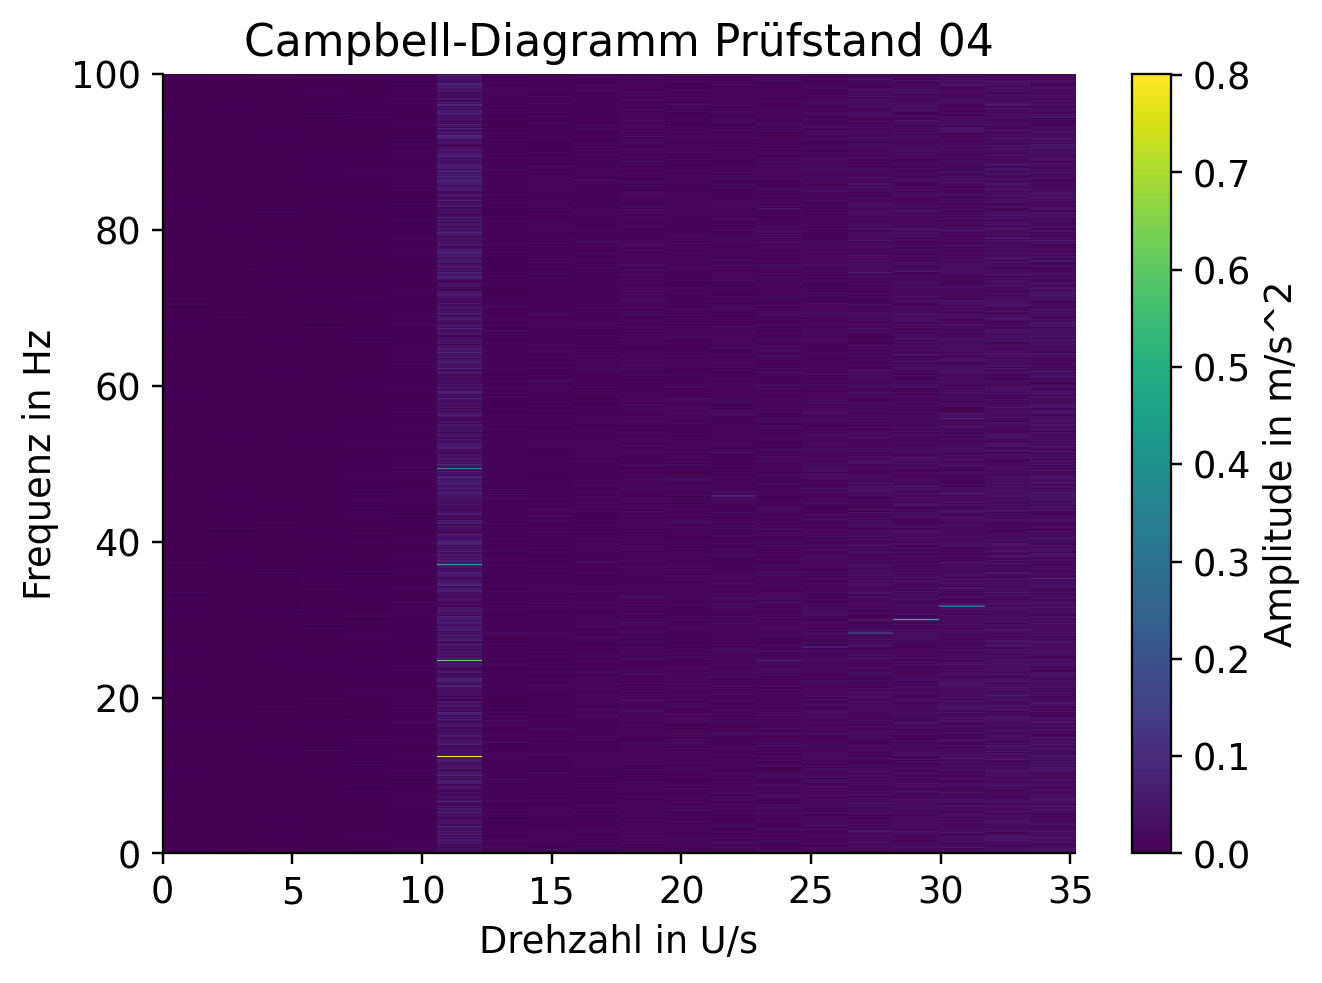

In [19]:
# Plot the Campbell Diagram
plt.imshow(np.transpose(amps), extent =[0, max(motor_rpm)/60, 0, 100], interpolation ='none', aspect ='auto', origin ='lower')
plt.xlabel('Drehzahl in U/s')
plt.ylabel('Frequenz in Hz')
plt.title('Campbell-Diagramm Prüfstand 04')
plt.colorbar(label='Amplitude in m/s^2')

## Diskussion
Diskutieren Sie die Ergebnisse Ihrer Experimente aus wissenschaftlicher Sicht, gehen Sie dabei insbesondere auch auf die zu Beginn aufgestellte Forschungsfrage ein. Beispielsweise können Sie hier auf Einschränkungen der Aussagekraft der Ergebnisse eingehen.

In allen drei Campbell-Diagrammen sind die Amplituden der Schwingungsantworten als Funktion der Drehzahl abzulesen. Dabei sind die Drehzahlen auf der x-Achse in Umdrehungen pro Sekunde (U/s), die Frequenzen der Schwingungsantworten auf der y-Achse in Hz und die Amplituden mithilfe einer Farbskala in m/s^2 angegeben.

Bei Prüfstand 02 tritt laut Campbell-Diagramm bei Drehzahlen von ca. 15, 22 und 50 U/s eine signifikante Amplitudenverstärkung auf. Dabei fällt auf, dass bei einer Drehzahl von 15 U/s im Gegensatz zu den anderen beiden genannten Drehzahlen eine Schwingungsanregung bei ca. 70 bis 75 Hz auftritt statt bei einer Frequenz mit dem gleichen Wert wie der von der Drehzahl. Insgesamt sind bei diesem Rotor allerdings zwei kritische Bereiche zu erkennen, nämlich zum einen zwischen 15 und 25 Hz und zum anderen in der Nähe von 50 Hz, der höchsten Drehzahl mit der das System beaufschlagt wurde. Falls also im Betrieb eine Drehzahl von weniger als 50 U/s angestrebt wird, sollte der erste kritische Drehzahlbereich vom Rotor schnell durchfahren werden, um eine schwere Beschädigung auszuschließen.

Bei Prüfstand 03 ist eine signifikante Amplitudenverstärkung bei einer Drehzahl von ca. 22 U/s, der kritische Bereich des Rotors liegt, wie im Campbell-Diagramm zu erkennen ist, zwischen 16 und 24 Hz. Dort befindet sich das System in Resonanz und damit besteht die Gefahr eine Beschädigung.

Bei Prüfstand 04 findet eine signifikante Amplitudenverstärkung einer Drehzahl von ca. 30 U/s statt, es befindet sich ein kritischer Bereich zwischen 27 und 32 Hz, in welchem es zur Anregung der Eigenfrequenz des Systems kommt. Bei diesem Rotor ist allerdings ebenfalls bei einer Drehzahl von ca. 11 U/s eine Schwingungsanregung des gesamten auf der y-Achse aufgetragenen Frequenzbereiches statt, wobei einzelne Frequenzen eine besonders starke Amplitudenverstärkung aufweisen. Dies könnte daran liegen, dass es bei dieser Drehzahl aufgrund von großen Schwingradien zur Berührung zwischen Welle und Fanglager kommt.

Alle drei Rotoren haben aufgrund der unterschiedlichen Scheibenmassen und -anzahl verschiedene kritische Drehzahlbereiche, die im Betrieb vermieden werden sollten. Aufgrund der verschiedenen Eigenschaften unterscheiden sich also die drei Prüfstände hinsichtlich ihrer rotordynamischen Stabilität in ihren Eigenfrequenzen und damit einhergehend in ihrem Schwingverhalten.
Dass eine Selbstzentrierung der Rotoren stattfindet, kann in den Messdaten darin gesehen werden, dass die Amplitudenverstärkung nach dem Aufschwingen der Rotoren in den kritischen Drehzahlbereichen wieder stark abnimmt.

##### Vergleich der gemessenen mit der analytisch berechneten kritischen Drehzahl
Sie können für den Vergleich, falls benötigt auch Code Cells einfügen.

Für Prüfstand 02 wurden zwei kritische Drehzahlen analytisch bestimmt. Die erste liegt bei ca. 769 Umdrehungen pro Minute bzw. 12,8 Umdrehungen pro Sekunde und die zweite bei ca. 2978 Umdrehungen pro Minute bzw. 49,6 Umdrehungen pro Sekunde. Die zweite kritische Drehzahl liegt also genau in dem oben genannten zweiten kritischen Bereich bei 50 Hz. Allerdings liegt die erste kritische Drehzahl nicht ganz in dem ersten kritischen Drehzahlbereich zwischen 15 und 25 Hz. Das könnte möglicherweise daran liegen, dass die Dämpfung des Systems die Eigenfrequenzen verändert und damit die tatsächlichen Eigenfrequenzen sich von den berechneten Werten unterscheiden. Außerdem kann es sein, dass die kritischen Drehzahlen aufgrund der vereinfachenden Annahmen für die analytische Berechnung leicht von den tatsächlichen Werten abweichen. Eine weitere mögliche Fehlerquelle könnte auch die zu große Schrittweite zwischen den getesteten Drehzahlen sein, die dazu führt, dass das System nicht exakt mit der kritischen Drehzahl beaufschlagt wird.

Letzten Endes konnten jedoch die beiden anfangs gestellten Forschungsfragen beantwortet werden. Zum einen ist klar geworden, dass die analytisch berechneten kritischen Drehzahlen in den Campbell-Diagrammen wiedergefunden werden können. Allerdings ist diese nicht als einzelner Punkt sondern als kritischer Bereich zu erkennen und die Werte in den Diagrammen weichen teilweise leicht von den berechneten Werten ab. Zum anderen ist ersichtlich geworden, dass sich die kritischen Drehzahlbereiche und die Eigenfrequenzen der drei verschiedenen Rotoren deutlich unterscheiden, jedoch liegen sie alle in der gleichen Größenordnung.

## Fazit
Ziehen Sie ein Fazit zum durchgeführten Versuch, gehen Sie dabei gerne auf Ihrer persönliche Meinung oder Ihre Lernziele ein.

Der letzte Versuch des Praktikums Digitalisierung war wie auch die anderen Versuche anschaulich und interessant. Die Aufgabenstellung hat es erfordert, sowohl analytisch Werte für die kritischen Drehzahlen zu berechnen als auch diese versuchen experimentell zu bestimmen. Mithilfe dieses Versuches konnte ich mein Wissen und Verständnis über Laval-Rotoren erweitern und das Erstellen und Interpretieren von Campbell-Diagrammen hat die gesamte Geschichte etwas anschaulicher gemacht.